In [1]:
using Plots, LaTeXStrings, Statistics, JLD, ProgressMeter, StatsBase, StatsPlots, Distributions

# figpath = "../Figs/"
# datapath = "../Data/"
# animpath = "../Anims/"
Plots.default(titlefontsize = 12, tickfontsize = 10, labelfontsize = 12, legendfontsize = 9,
    fontfamily = "Computer Modern", frame = :box, label = nothing)

In [2]:
mutable struct EpNetwork{DT<:AbstractFloat}
    α::DT
    β::DT
    γ::DT
    P₀::DT
    NS::Integer
    Network::Matrix{Int8}
    function EpNetwork(α::DT, β::DT, γ::DT, P₀::DT, NS::Integer) where {DT<:AbstractFloat}
        Network = reshape(sample(Int8[1, 0], Weights([P₀, 1 - P₀]), NS * NS), (NS, NS))
        return new{DT}(α, β, γ, P₀, NS, Network)
    end
end

function get_neighbor(index::Vector{Int64}, sys::EpNetwork)
    function fix_bounds(neighbors::Vector, sys::EpNetwork)
        neighbors[findall(x -> x == 0, neighbors)] .= sys.NS
        neighbors[findall(x -> x == sys.NS + 1, neighbors)] .= 1
        return neighbors
    end
    neighbors = [index[1] - 1, index[2], index[1] + 1, index[2], index[1], index[2] - 1, index[1], index[2] + 1]
    neighbors = fix_bounds(neighbors, sys)
    return CartesianIndex.([(neighbors[1], neighbors[2]), (neighbors[3], neighbors[4]), (neighbors[5], neighbors[6]), (neighbors[7], neighbors[8])])
end

mutable struct Neighbors
    Indices::Vector{CartesianIndex}
    Values::Vector{Int8}
    function Neighbors(index::Vector{Int64}, sys::EpNetwork)
        indices = get_neighbor(index, sys)
        values = sys.Network[indices]
        return new(indices, values)
    end
end

function update!(sys::EpNetwork)
    indices = [rand(1:sys.NS, 2) for _ ∈ 1:sys.NS^2]
    S_indices = findall(x -> sys.Network[x...] == 0 && 1 ∈ Neighbors(x, sys).Values, indices)
    sys.Network[S_indices] += sample(Int8[0, 1], weights([1 - sys.β, sys.β]), length(S_indices))
    I_indices = findall(x -> sys.Network[x...] == 1, indices)
    sys.Network[I_indices] += sample(Int8[0, 1], weights([1 - sys.γ, sys.γ]), length(I_indices))
    R_indices = findall(x -> sys.Network[x...] == 2, indices)
    sys.Network[R_indices] .*= sample(Int8[1, 0], weights([1 - sys.α, sys.α]), length(R_indices))
    sys.Network[findall(x -> x > 2, sys.Network)] .= 2
end

update! (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = c:\Users\shahm\Desktop\tmp.gif
└ @ Plots C:\Users\shahm\.julia\packages\Plots\1KWPG\src\animation.jl:114


Plots.AnimatedGif("c:\\Users\\shahm\\Desktop\\tmp.gif")
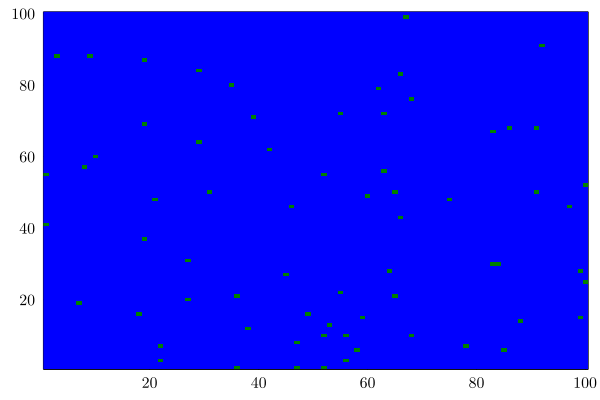

In [15]:
sys = EpNetwork(1/60, 1/20, 1/10, 0.005, 100)
@gif for _ ∈ 1:1000
    update!(sys)
    heatmap(sys.Network, c = cgrad([:blue, :red, :green], 3), legend = false)
end